<div style="width: 100%; clear: both;">
    <div style="float: left; width: 50%;">
        <img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
    </div>
</div>
<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;">M2.876 · Análisis de grafos y redes sociales</p>
    <p style="margin: 0; text-align:right;">Máster universitario en Ciencias de Datos (<i>Data Science</i>)</p>
    <p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
<div style="width: 100%; clear: both;"></div>
<div style="width:100%;">&nbsp;</div>

# Predicción de enlaces (_link prediction_)

En este _notebook_ veremos un ejemplo sencillo sobre cómo aplicar la predicción de enlaces.

## Carga de librerías

En la siguiente celda se deben cargar todas las librerías necesarias para ejecutar la actividad. Se debe justificar el uso de librerías adicionales.

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import scipy.sparse as sp
import json
import collections
import matplotlib.pyplot as plt

import random

## Parte 1. Carga del conjunto de datos

En esta actividad vamos a trabajar con un conjunto de datos que proviene de _streamers_ de Twitch de habla hispana. Se dispone de dos ficheros: 
- **edgelist.edgelist**: Contiene los enlaces entre dos jugadores. Suponemos que la red es no dirigida y que dos jugadores tienen un enlace cuando se siguen mutuamente.
- **ES_features.json**: Contiene todos los atributos de cada nodo. Utilizaremos este fichero en la parte 3 de la PEC.

En esta parte exploraremos el grafo dado a partir de la lista de enlaces. Para ello:

1. Crearemos el grafo no dirigido ni ponderado a partir del fichero *edgelist.edgelist*. 

2. Describiremos algunas de sus propiedades, como el número de nodos, número de aristas, distribución de grado, número de comunidades conectadas y la correspondiente medida de estas.

2. Crearemos y representaremos gráficamente un subgrafo que contenga 800 nodos (con sus correspondientes aristas) escogidos al azar. 

In [ ]:
def plot_deg_distr(g):
    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()
    return 

def properties_G(g):
    num_nodes_g = nx.number_of_nodes(g)
    num_edges_g = nx.number_of_edges(g)
    max_num_edges = num_nodes_g*(num_nodes_g-1)/2
    print('Number of nodes ',num_nodes_g)
    print('Number of edges ',num_edges_g)
    n_nodes = nx.number_of_edges(g)
    print("Density {}".format(nx.number_of_edges(g)/(n_nodes*(n_nodes-1)/2)))
    plot_deg_distr(g)
    print('is connected g: {}'.format(nx.is_connected(g)))
    print('number connected components:',len(list(nx.connected_components(g))))
    print('size 10th biggest connected components:\n{}'.format(sorted(list(map(len,nx.connected_components(g))),reverse=True)[:10]))
    return

Number of nodes  4648
Number of edges  59382
Density 3.368080699213553e-05


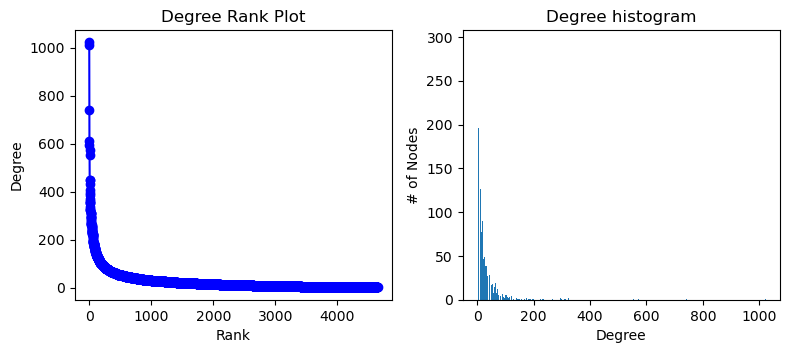

is connected g: True
number connected components: 1
size 10th biggest connected components:
[4648]


In [ ]:
# LOAD GRAPH and show properties
G = nx.read_edgelist('data/edgelist.edgelist')

# properties
properties_G(G)

In [ ]:
# Create and plot subgraph
random.seed(0)
n = 800 # number nodes subgraph to work on
nodes_g = random.sample(list(G.nodes()), k=n)
g = nx.subgraph(G,nodes_g)

Properties subgraph
Number of nodes  800
Number of edges  1968
Density 0.0010167768174885613


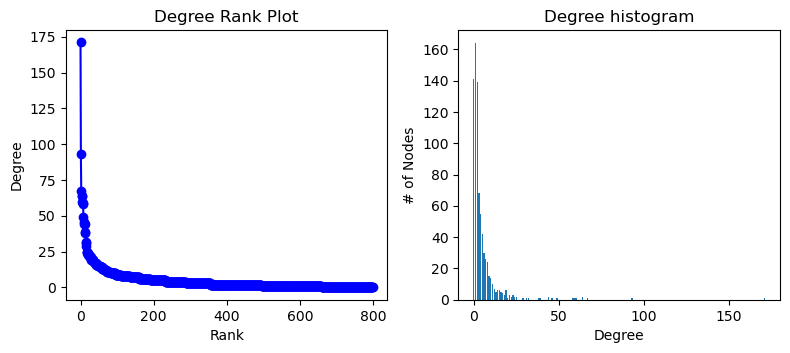

is connected g: False
number connected components: 150
size 10th biggest connected components:
[642, 3, 2, 2, 2, 2, 2, 2, 2, 1]


In [ ]:
print('Properties subgraph')
properties_G(g)

## Parte 2. Predicción de enlaces basándose en la topología de la red


Algunas veces los datos proporcionados no son correctos y nos faltan enlaces, o nos gustaría saber cuáles serían los enlaces más probables. En este caso trataremos de determinar qué método sería el más adecuado para predecir enlaces en nuestra red. 

**Nota**: como estamos trabajando con una red bastante grande, en este ejercicio partiremos de un subgrafo que contendrá 800 nodos.

Una vez creado el subgrafo, tendremos que dividir el conjunto de aristas en dos partes: *train* y *test*. El *train* contendrá un 60 % de las aristas del grafo original.

Usaremos los siguientes métodos para predecir aristas:
- índice de vecinos comunes (*allocation index*)
- índice de conexión preferencial

Para evaluar la bondad del método en nuestro grafo, usaremos la función AUC-ROC. 

Usaremos las funciones ya programadas en Python, tanto para el cálculo de los diferentes índices como para la AUC-ROC (que está disponible en `sklearn.metrics.roc_auc_score`).

In [ ]:
def create_all_edges(g):
    edges = []
    for i in g.nodes():
        for j in g.nodes():
            if i<j:
                edges.append((i,j))
    return edges

In [ ]:
# num_edges_g = nx.number_of_edges(G)
num_nodes_g = nx.number_of_nodes(g)
num_edges_g = nx.number_of_edges(g)

In [ ]:
# list all possible edges (complete graph)
all_possible_edges = create_all_edges(g)
max_num_edges = len(all_possible_edges)
print('all possible edges ', max_num_edges)
assert len(all_possible_edges) == num_nodes_g*(num_nodes_g-1)/2

all possible edges  319600


In [ ]:
# select train size
size_train = round(0.6*num_edges_g) # we are asked to have a train set with 60% of edges
print('size to train ',size_train)

# train
edges_train = random.sample(list(g.edges()), k=size_train)
g_train = nx.Graph()
g_train.add_nodes_from(g.nodes()) # add all possible nodes
g_train.add_edges_from(edges_train) # add selected edges
print('g train nodes: {}\ng_train edges: {}'.format(nx.number_of_nodes(g_train), len(edges_train)))

# test
edges_test = set(g.edges())-set(edges_train)
g_test = nx.Graph()
g_test.add_nodes_from(G.nodes())
g_test.add_edges_from(edges_test)
print('g test nodes: {}\ng test edges:{}'.format(nx.number_of_nodes(g_test),len(edges_test)))

size to train  1181
g train nodes: 800
g_train edges: 1181
g test nodes: 4648
g test edges:787


### Cálculo de las métricas de similitud

Aplicaremos este cálculo sobre el conjunto de datos de entrenamiento (_train_). 

In [ ]:
dict_scores = dict() # dict to save scores

In [ ]:
# Allocation index
method = 'allocation'
preds_alloc = nx.resource_allocation_index(g_train, ebunch=all_possible_edges)
score_alloc = dict()
for u, v, p in preds_alloc:
    score_alloc[(u,v)] = p
#     print('(%s, %s) -> %.8f' % (u, v, p))
    
dict_scores[method]=score_alloc
assert len(score_alloc) == max_num_edges

In [ ]:
# Preferential attachment
method = 'pref_attach'
preds_pref_att = nx.preferential_attachment(g_train, ebunch=all_possible_edges)
score_pref_att = dict()
for u, v, p in preds_pref_att:
    score_pref_att[(u,v)] = p
#     print('(%s, %s) -> %.8f' % (u, v, p))

dict_scores[method]=score_pref_att
assert len(score_pref_att) == max_num_edges

A continuación, calcularemos el valor de AUC-ROC empleando el conjunto de datos de test (_test_).

In [ ]:
def compute_auc_score(g_test, edges, scores):
    d = {}
    test_edges = set(g_test.edges())
    for e in edges:
        if e in test_edges or (e[1],e[0]) in test_edges:
            d[e] = (1, None)
        else:
            d[e] = (0, None)
        if e in scores:
            d[e] = (d[e][0],scores[e])
        elif (e[1],e[0]) in scores:
            d[e] =  (d[e][0],scores[(e[1],e[0])])

    y_true, y_score = [],[]
    for e in d:
        y_true.append(d[e][0])
        y_score.append(d[e][1])

    auc  = roc_auc_score(y_true,y_score)
    return auc

In [ ]:
methods = ['alloc','pref_attch']
scores = [score_alloc, score_pref_att]
scores_dict = {m: s for m, s in zip(methods,scores)}

In [ ]:
with_train_edges = set(g_train.edges())
edges2evaluate = []
for i in all_possible_edges:
    if (i in with_train_edges or (i[1],i[0]) in with_train_edges)==False:
        if i[0]<i[1]:
            edges2evaluate.append(i) 
        else:
            edges2evaluate.append((i[1],i[0])) 

In [ ]:
from sklearn.metrics import roc_auc_score

print("ALLOC      {}".format(compute_auc_score(g_test, edges2evaluate, score_alloc)))
print("Pref Attch {}".format(compute_auc_score(g_test, edges2evaluate, score_pref_att)))

ALLOC      0.6802455907194817
Pref Attch 0.8309678605479788


In [ ]:
auc_dict1 = dict()
auc_dict1 = {m: compute_auc_score(g_test, edges2evaluate, s) for m, s in zip(methods,scores)}
    
auc_dict1

{'alloc': 0.6802455907194817, 'pref_attch': 0.8309678605479788}